In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import fdrcorrection as fdr
from scipy import stats
import itertools

In [2]:
#Load data
Introns_info=pd.read_csv('Intron_infos.tsv',sep='\t')

In [3]:
Introns_info['PTC_inducing']=Introns_info.PTC_inducing.apply(lambda x: 1 if x=='visible' else -1)
Introns_info['Acceptor']=Introns_info.Acceptor.apply(lambda x: 1 if x==1 else -1)
Introns_info['Donor']=Introns_info.Donor.apply(lambda x: 1 if x==1 else -1)
Introns_info['X3n_class']=Introns_info.X3n_class.apply(lambda x: 1 if x=='3n' else -1)

#add distances form TSS
Introns_info['rel_distance_from_TSS']=Introns_info.distance_from_TSS/Introns_info.Transcript_size


In [4]:
#function that applies a transformation and standardizes data
def norm_data_apply_function(x,FUN='A'):
    if FUN!='A':
        y=FUN(x)
    else:
        y=x
    y=(y-np.mean(y))/np.std(y)
    return(y)

Introns_info=Introns_info.assign(
    
#RPKM
RPKM_WT=norm_data_apply_function(Introns_info.RPKM_WT,np.log10),

#local density
density=norm_data_apply_function(Introns_info.density),

#distance from center 
distance_center=norm_data_apply_function(Introns_info.distance_center),

#GC
GC=norm_data_apply_function(Introns_info.GC),
GC_nextExon=norm_data_apply_function(Introns_info.GC_nextExon),
GC_prevExon=norm_data_apply_function(Introns_info.GC_prevExon),
GC_Transcrip=norm_data_apply_function(Introns_info.GC_Transcrip),  
#TC
TC=norm_data_apply_function(Introns_info.TC),
TC_nextExon=norm_data_apply_function(Introns_info.TC_nextExon),
TC_prevExon=norm_data_apply_function(Introns_info.TC_prevExon),
TC_Transcrip=norm_data_apply_function(Introns_info.TC_Transcrip),  
#TG
TG=norm_data_apply_function(Introns_info.TG),
TG_nextExon=norm_data_apply_function(Introns_info.TG_nextExon),
TG_prevExon=norm_data_apply_function(Introns_info.TG_prevExon),
TG_Transcrip=norm_data_apply_function(Introns_info.TG_Transcrip),

#DeltaGC
DeltaGC=norm_data_apply_function(Introns_info.DeltaGC),

#MNase
MNase=norm_data_apply_function(Introns_info.MNase),
MNase_nextExon=norm_data_apply_function(Introns_info.MNase_nextExon),
MNase_prevExon=norm_data_apply_function(Introns_info.MNase_prevExon),
    
#size
Transcript_size=norm_data_apply_function(Introns_info.Transcript_size),
len_intron=norm_data_apply_function(Introns_info.len_intron),
nextExon_Size=norm_data_apply_function(Introns_info.nextExon_Size),
prevExon_Size=norm_data_apply_function(Introns_info.prevExon_Size),
    
#introns prop
Count=norm_data_apply_function(Introns_info.Count),
        
#splicing
Donor=norm_data_apply_function(Introns_info.Donor),
Acceptor=norm_data_apply_function(Introns_info.Acceptor),
    
# free energy 
DeltaG_50b=norm_data_apply_function(Introns_info.DeltaG_50b),
DeltaG_50b_int=norm_data_apply_function(Introns_info.DeltaG_50b_int),
DeltaG_50b_int_50a=norm_data_apply_function(Introns_info.DeltaG_50b_int_50a),    

#binary info
PTC_inducing=norm_data_apply_function(Introns_info.PTC_inducing)    ,
X3n_class=norm_data_apply_function(Introns_info.X3n_class),
    
#splicing 
Splice_eff_WT=norm_data_apply_function(Introns_info.Splice_eff_WT,np.exp), 
Splice_eff_NMD=norm_data_apply_function(Introns_info.Splice_eff_NMD,np.exp), 

#distances from TSS
distance_from_TSS=norm_data_apply_function(Introns_info.distance_from_TSS),
rel_distance_from_TSS=norm_data_apply_function(Introns_info.rel_distance_from_TSS),
distance_from_TTS=norm_data_apply_function(Introns_info.distance_from_TTS)

    
).dropna()


In [5]:
List_par=[ 'RPKM_WT',
          'X3n_class',
          'distance_center',
          'distance_from_TTS',
          'distance_from_TSS',
          'rel_distance_from_TSS',
          'Transcript_size',
          'nextExon_Size',
          'prevExon_Size',
          'MNase', 
          'MNase_nextExon','MNase_prevExon', 
          'len_intron',
          'Count',
          'density',
          'DeltaGC',
          'Acceptor',
          'Donor',
          'GC',
          'TC','TG',
          'PTC_inducing',
          'GC_nextExon','TC_nextExon','TG_nextExon',
          'GC_prevExon','TC_prevExon','TG_prevExon',
          'GC_Transcrip','TC_Transcrip','TG_Transcrip',
          'DeltaG_50b','DeltaG_50b_int','DeltaG_50b_int_50a'
         ]
full_list=['Splice_eff_WT','Splice_eff_NMD']+List_par

In [6]:
Introns_info[full_list].describe()

,Splice_eff_WT,Splice_eff_NMD,RPKM_WT,X3n_class,distance_center,distance_from_TTS,distance_from_TSS,rel_distance_from_TSS,Transcript_size,nextExon_Size,...,TG_nextExon,GC_prevExon,TC_prevExon,TG_prevExon,GC_Transcrip,TC_Transcrip,TG_Transcrip,DeltaG_50b,DeltaG_50b_int,DeltaG_50b_int_50a
count,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,...,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04,6.965800e+04
mean,4.045155e-12,1.321364e-12,-1.116448e-15,7.423822e-16,4.195412e-17,-4.538781e-17,3.164848e-17,4.721131e-15,1.392999e-17,-3.493653e-18,...,-4.411562e-14,1.532250e-13,2.006133e-14,-1.266836e-13,-1.086060e-14,-1.391363e-13,4.184762e-13,-2.638027e-16,1.807997e-16,-3.943333e-16
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-5.372914e+00,-5.196656e+00,-3.621905e+00,-4.821519e-01,-9.257151e-01,-9.352143e-01,-7.806738e-01,-1.675638e+00,-1.211025e+00,-7.231999e-01,...,-9.635849e+00,-6.663413e+00,-8.044073e+00,-9.340241e+00,-6.760029e+00,-1.032563e+01,-1.206010e+01,-5.201786e+00,-5.420686e+00,-4.365603e+00
25%,-4.901510e-02,-5.397982e-02,-6.904943e-01,-4.821519e-01,-4.797218e-01,-6.247539e-01,-5.491753e-01,-9.068735e-01,-5.626757e-01,-4.443104e-01,...,-6.459120e-01,-6.632979e-01,-5.951607e-01,-6.397878e-01,-7.129106e-01,-5.542913e-01,-6.458151e-01,-6.321613e-01,-6.198201e-01,-6.485784e-01
50%,4.681651e-01,4.229886e-01,-1.319041e-01,-4.821519e-01,-1.058745e-01,-2.762985e-01,-2.910973e-01,-5.412696e-02,-2.440664e-01,-2.962104e-01,...,4.503591e-03,-3.109408e-02,3.958773e-02,1.467102e-02,-4.827374e-02,6.147381e-02,2.502241e-02,1.048750e-01,4.345742e-02,4.296129e-02
75%,5.428969e-01,5.760754e-01,5.783940e-01,-4.821519e-01,1.827094e-01,2.656322e-01,1.697562e-01,9.185288e-01,1.907171e-01,4.230381e-02,...,6.278647e-01,6.426524e-01,6.171245e-01,6.271694e-01,6.661538e-01,6.244757e-01,6.438691e-01,7.313558e-01,7.067349e-01,6.912796e-01
max,5.428969e-01,5.854068e-01,5.275546e+00,2.074035e+00,6.334979e+01,1.433733e+01,1.754072e+01,1.830794e+00,1.369961e+01,2.521353e+01,...,6.137064e+00,6.245117e+00,1.019292e+01,1.023578e+01,4.404133e+00,3.799497e+00,5.019954e+00,1.652651e+00,2.443890e+00,3.327774e+00


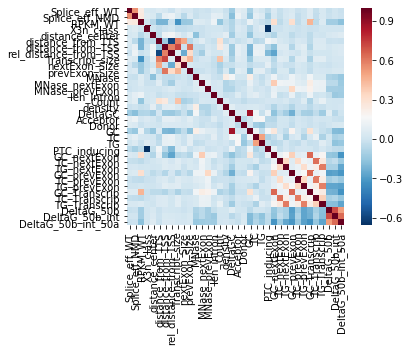

In [7]:
#check data correlation
#calculate correlation matrix
corr = Introns_info[full_list].corr()

# plot correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', square=True)

plt.savefig('Model_correlations.pdf',  format='pdf')


In [8]:
#calcualates variance inflation factor and exclude variables
def select_variables(Info,Par):
    RUN=True
    P=Par
    excluded=[]
    while RUN:
        x=Info[P]
        vif= pd.DataFrame()
        vif['variables']=x.columns
        vif["VIF"]=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
        if np.any(vif.VIF >= 5):
            highest=vif.sort_values(['VIF'],ascending=False).reset_index(drop=True).iloc[0,0]
            P=[p for p in P if p != highest]
            excluded.append(highest)
        else :
            RUN = False
    print(excluded)
    return (P)



In [9]:
# excluded parameters select based on VIF and print out excluded 

List_par=select_variables(Introns_info,List_par)

/Users/sgnan/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


['DeltaGC', 'distance_from_TTS', 'distance_from_TSS']


In [10]:
List_par

['RPKM_WT',
 'X3n_class',
 'distance_center',
 'rel_distance_from_TSS',
 'Transcript_size',
 'nextExon_Size',
 'prevExon_Size',
 'MNase',
 'MNase_nextExon',
 'MNase_prevExon',
 'len_intron',
 'Count',
 'density',
 'Acceptor',
 'Donor',
 'GC',
 'TC',
 'TG',
 'PTC_inducing',
 'GC_nextExon',
 'TC_nextExon',
 'TG_nextExon',
 'GC_prevExon',
 'TC_prevExon',
 'TG_prevExon',
 'GC_Transcrip',
 'TC_Transcrip',
 'TG_Transcrip',
 'DeltaG_50b',
 'DeltaG_50b_int',
 'DeltaG_50b_int_50a']

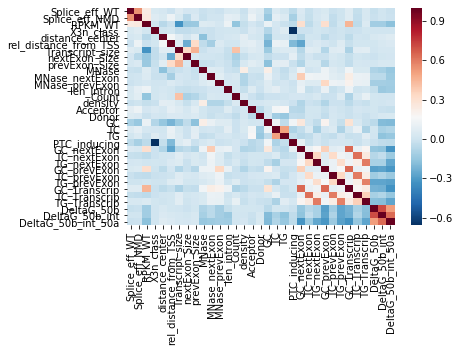

In [11]:
#check data correlation
#calculate correlation matrix
corr = Introns_info[['Splice_eff_WT','Splice_eff_NMD']+List_par].corr()

#plot correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r')


In [12]:
# caclulates contribution
def calculate_model_info(Mult_lin,corr,col_corr):
    coef_fd=pd.DataFrame({'coef':Mult_lin['Model'].coef_,'index':Mult_lin['list_par']})
    coef_fd=corr[col_corr].reset_index().merge(coef_fd, on='index', how='inner')
    coef_fd=coef_fd.assign(   CorCoef=abs(coef_fd[col_corr]*coef_fd.coef)
                              )
    TotalCorrelation=sum(coef_fd.CorCoef)
    coef_fd=coef_fd.assign(
            Contribution=100*(coef_fd.CorCoef)/TotalCorrelation
        ).sort_values(["Contribution"],ascending=False).merge(
            Mult_lin['Info'].rename(columns={'param':'index'}
                     ).filter(["index","Standard Errors","t values","pVal",'adj_pval','Sig']), on='index', how='inner')
    return coef_fd


In [13]:
def fit_data(genes_info,COL,list_par):
    mat_genes_info=np.matrix(genes_info[list_par])

    X_train, X_test, y_train, y_test = train_test_split(mat_genes_info,genes_info[COL].values, test_size=0.1, random_state=0)
    Mult_lin= LinearRegression()
    Mult_lin.fit(X_train, y_train)

    newX = pd.DataFrame({"Constant":np.ones(len(X_train))}).join(pd.DataFrame(X_train).reset_index(drop=True))
    MSE = (sum((y_train-Mult_lin.predict(X_train))**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b =  np.append(Mult_lin.intercept_,Mult_lin.coef_)/ sd_b
    p_values =np.array([2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b] )
    adj_pval=fdr(p_values)
    params =np.append(Mult_lin.intercept_,Mult_lin.coef_)
    
    myDF3 = pd.DataFrame()
    myDF3["param"],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["pVal"],myDF3["adj_pval"],myDF3["Sig"] = [['constant']+list_par,params,sd_b,ts_b,p_values,adj_pval[1],adj_pval[0]
        ]

    return {'Info':myDF3,'Model':Mult_lin,'X_test':X_test,'y_test':y_test,'list_par':list_par}



In [14]:
old_paramentes=[]
Final_List_par=List_par
excluded ={}
while set(old_paramentes)!=set(Final_List_par):
    old_paramentes=Final_List_par
    Mult_lin_NMD=fit_data(Introns_info,'Splice_eff_NMD',Final_List_par)
    data=calculate_model_info(Mult_lin_NMD,corr,'Splice_eff_NMD')
    Final_List_par=[i for i in data.query('Sig')['index'].values]
    for i,p in data.query('Sig==False')[['index','adj_pval']].values:
        excluded[i]=p

#excluded parameters 
excluded

{'prevExon_Size': 0.2910297690876879,
 'TC_prevExon': 0.4492892414127173,
 'MNase_prevExon': 0.29868823194657923,
 'density': 0.21060964070644822}

In [15]:
Mult_lin_NMD=fit_data(Introns_info,'Splice_eff_NMD',Final_List_par)
data=calculate_model_info(Mult_lin_NMD,corr,'Splice_eff_NMD')


In [16]:
pd.DataFrame({
'Real_NMD':Mult_lin_NMD['y_test'],
'Model_NMD':Mult_lin_NMD['Model'].predict(Mult_lin_NMD['X_test'])
}).corr()

,Real_NMD,Model_NMD
Real_NMD,1.000000,0.387931
Model_NMD,0.387931,1.000000


In [18]:
sub=data[['index','Contribution']]

Change={
    'RPKM_WT':'Espression Level',
    'GC':'Intron base composition',
    'Acceptor':'Splicing',
    'TC':'Intron base composition',
    'rel_distance_from_TSS':'Intron Size and position',
    'Count':'Transcript Size and base composition',
    'len_intron':'Intron Size and position',
    'NMD sensibility':'PTC_inducing',
    'Donor':'Splicing',
    'Transcript_size':'Transcript Size and base composition',
    'GC_Transcrip':'Transcript Size and base composition',
    'TG':'Intron base composition',
    'nextExon_Size':'Flanking exons size and base composition',
    'X3n_class':'X3n_class',
    'TG_Transcrip':'Transcript Size and base composition',
    'TC_Transcrip':'Transcript Size and base composition',
    'GC_nextExon':'Flanking exons size and base composition',
    'GC_prevExon':'Flanking exons size and base composition',
    'TG_nextExon':'Flanking exons size and base composition',
    'TC_nextExon':'Flanking exons size and base composition',
    'distance_center':'Nucleosome position',
    'MNase':'Nucleosome position',
    'MNase_nextExon':'Nucleosome position',
    'TG_prevExon':'Flanking exons size and base composition',
    'DeltaG_50b':'Secondary structures',
    'DeltaG_50b_int':'Secondary structures',
    'DeltaG_50b_int_50a':'Secondary structures'

    
}
sub=sub.assign(index=sub['index'].apply(lambda x: Change[x] if x in Change.keys() else x))
sub=sub.groupby('index').agg({'Contribution':'sum'}).sort_values(['Contribution'],ascending=False).reset_index()
sub=sub.rename(columns={'Contribution':'ToT_Contribution'})
sub.ToT_Contribution=np.round(sub.ToT_Contribution,2)

sub

,index,ToT_Contribution
0,Espression Level,46.09
1,Intron base composition,22.23
2,Splicing,9.55
3,Transcript Size and base composition,8.71
4,Intron Size and position,7.08
5,PTC_inducing,2.46
6,Flanking exons size and base composition,2.45
7,X3n_class,0.66
8,Nucleosome position,0.43
9,Secondary structures,0.35


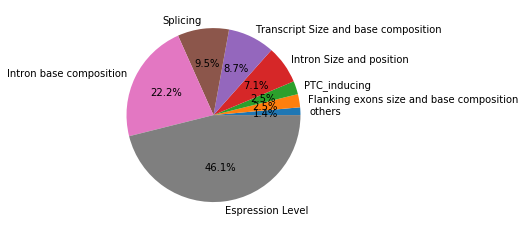

In [19]:
sub_sub=sub.query('ToT_Contribution > 1 ').reset_index()
sub_sub=sub_sub.append({'index':'others','ToT_Contribution':100-sub_sub.ToT_Contribution.values.sum()},ignore_index=True)
sub_sub.set_index(['index']).sort_values(['ToT_Contribution']).ToT_Contribution.plot(kind='pie', autopct='%1.1f%%',
         startangle=0, label='')

plt.savefig('Model_contribution_pie.pdf',  format='pdf')

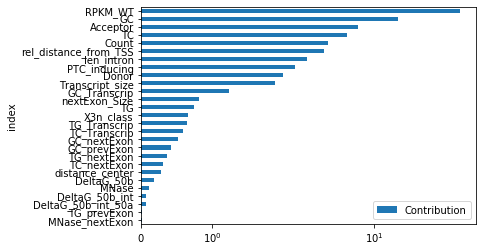

In [20]:
data[['index','Contribution']].sort_values('Contribution').set_index(['index']).plot(kind='barh')
plt.xscale('symlog')

plt.savefig('Model_contribution.pdf',  format='pdf')

In [21]:
' '.join(data[['coef','index']].apply(lambda x:["", "+ "][x[0] > 0]+np.round(x[0],3).astype('str')+' x '+x[1],1).values)

'+ 0.295 x RPKM_WT -0.17 x GC + 0.098 x Acceptor + 0.109 x TC + 0.09 x Count + 0.054 x rel_distance_from_TSS + 0.052 x len_intron -0.037 x PTC_inducing + 0.067 x Donor + 0.074 x Transcript_size -0.03 x GC_Transcrip -0.023 x nextExon_Size -0.024 x TG + 0.017 x X3n_class + 0.032 x TG_Transcrip -0.032 x TC_Transcrip + 0.026 x GC_nextExon + 0.013 x GC_prevExon + 0.023 x TG_nextExon -0.019 x TC_nextExon + 0.011 x distance_center -0.021 x DeltaG_50b + 0.01 x MNase + 0.018 x DeltaG_50b_int + 0.022 x DeltaG_50b_int_50a -0.023 x TG_prevExon + 0.009 x MNase_nextExon'

In [22]:
data=data[['index','Contribution','adj_pval']].assign(Groups=data['index'].apply(lambda x: Change[x] if x in Change.keys() else x))

data.Contribution=np.round(data.Contribution,2)
data.sort_values(['Groups','Contribution'],ascending=False)

,index,Contribution,adj_pval,Groups
13,X3n_class,0.66,8.838819e-04,X3n_class
4,Count,4.37,0.000000e+00,Transcript Size and base composition
9,Transcript_size,1.87,0.000000e+00,Transcript Size and base composition
10,GC_Transcrip,1.23,9.730258e-06,Transcript Size and base composition
14,TG_Transcrip,0.64,9.454290e-08,Transcript Size and base composition
15,TC_Transcrip,0.59,9.712360e-10,Transcript Size and base composition
2,Acceptor,7.56,0.000000e+00,Splicing
8,Donor,1.99,0.000000e+00,Splicing
21,DeltaG_50b,0.19,1.662289e-04,Secondary structures
23,DeltaG_50b_int,0.08,4.217958e-03,Secondary structures


In [23]:
Sensitive=Introns_info.query('PTC_inducing>0')[['Splice_eff_NMD']+Final_List_par]
insensitive=Introns_info.query('PTC_inducing<0')[['Splice_eff_NMD']+Final_List_par]

In [24]:
pd.DataFrame({
'Real_NMD-sensitive':Sensitive['Splice_eff_NMD'].values,
'Model_NMD-sensitive':Mult_lin_NMD['Model'].predict(np.matrix(Sensitive[Final_List_par]))
}).corr()

,Real_NMD-sensitive,Model_NMD-sensitive
Real_NMD-sensitive,1.000000,0.399889
Model_NMD-sensitive,0.399889,1.000000


In [25]:
pd.DataFrame({
'Real_NMD-insensitive':insensitive['Splice_eff_NMD'].values,
'Model_NMD-insensitive':Mult_lin_NMD['Model'].predict(np.matrix(insensitive[Final_List_par]))
}).corr()

,Real_NMD-insensitive,Model_NMD-insensitive
Real_NMD-insensitive,1.00000,0.27427
Model_NMD-insensitive,0.27427,1.00000
